### Import Libraries

In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML
import cv2 

In [31]:
# Define images and label path
root = Path('./Data/Task06_Lung/imagesTr/')
label = Path('./Data/Task06_Lung/labelsTr/')

In [7]:
# Define function to replace imagesTr with labelsTr
def images_to_labels(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

#### Preview Image

In [19]:
# Select a patient to view
sample_patient_path = list(root.glob("lung_*"))[5]
sample_patient_label = images_to_labels(sample_patient_path)

data = nib.load(sample_patient_path)
label = nib.load(sample_patient_label)

ct = data.get_fdata()
mask = label.get_fdata()


In [17]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

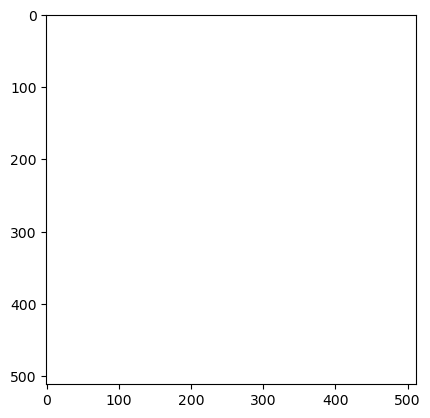

In [20]:
# Display image with mask
fig = plt.figure()
camera = Camera(fig)

for i in range(0, ct.shape[2], 2):
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    camera.snap()
animation = camera.animate()

In [21]:
# Convert animation into a video
from IPython.display import HTML
HTML(animation.to_html5_video())

### Preprocessing

In [35]:
# Import necessary libraries
import cv2
import numpy as np
import nibabel as nib
from pathlib import Path

# Define the function to preprocess images and labels
def preprocess(root, save_root):
    # Get a list of all files with names starting with "lung_"
    all_files = list(root.glob("lung_*")) 

    # Iterate through each CT scan in the list
    for scan, ct_scan_path in enumerate(all_files):
        # Create the corresponding label path for the CT scan
        ct_label_path = images_to_labels(ct_scan_path)

        # Load the CT scan data and the label data using nibabel
        ct_scan_data = nib.load(ct_scan_path).get_fdata()
        ct_label_data = nib.load(ct_label_path).get_fdata()

        # Crop the CT scan data and label data, starting from slice 30 and normalize the CT scan data
        ct_scan_data = ct_scan_data[:, :, 30:] / 3071
        ct_label_data = ct_label_data[:, :, 30:]

        # Create train and validation sets based on the scan index
        if scan < 55:
            current_path = save_root / "train" / str(scan)
        else:
            current_path = save_root / "val" / str(scan)

        # Loop over the slices in the full volume and store the data and labels in their respective data and mask directories
        for i in range(ct_scan_data.shape[-1]):
            # Extract the 2D slice and corresponding mask from the 3D CT scan data and label data
            slice = ct_scan_data[:, :, i]
            mask = ct_label_data[:, :, i]

            # Resize the slice and mask to 256x256 using cv2.resize()
            slice = cv2.resize(slice, (256, 256))
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            
            # Create the data and mask directories if they don't exist and save the 2D slice and mask as numpy arrays
            slice_path = current_path / "data"
            mask_path = current_path / "masks"
            slice_path.mkdir(parents=True, exist_ok=True)
            mask_path.mkdir(parents=True, exist_ok=True)
            
            np.save(slice_path / str(i), slice)
            np.save(mask_path / str(i), mask)

### Validate and visualize

In [36]:
save_root = Path("./Data/Task06_Lung/Preprocessed/")
preprocess(root, save_root)

In [37]:
path = Path("./Data/Task06_Lung/Preprocessed/train/30")  


In [38]:
list(path.glob("*"))

[PosixPath('Data/Task06_Lung/Preprocessed/train/30/data'),
 PosixPath('Data/Task06_Lung/Preprocessed/train/30/masks')]

In [42]:
file = "70.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

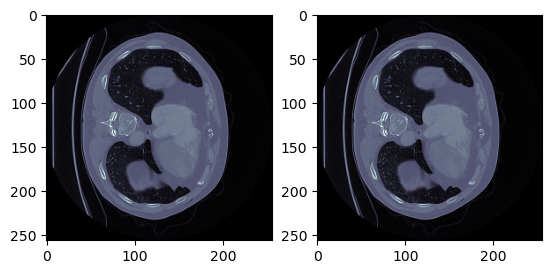

In [43]:
# Plot images 
fig, axis = plt.subplots(1, 2)
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")